# Romania

More turnout data than municipalities

In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None

## Fetch results

In [3]:
df = pd.read_excel('../../data/raw/rou.xlsx', skipfooter=93)

In [388]:
df = df[['Cod Birou Electoral', 'Nume Judet', 'Localitate',
         'Nr Alegatori Liste', 'Nr Alegatori Prezentati La Urne']]
df.columns = ['code', 'province', 'municipality', 'eligible', 'voters']
df['turnout'] = df.voters / df.eligible

In [389]:
df.province = df.province.str.replace('Ş', 'Ș')
df.province = df.province.str.replace('Ţ', 'Ț')
df.province = df.province.str.replace('Ş', 'Ș')

In [390]:
df.municipality = df.municipality.replace('INTREGALDE', 'ÃŽNTREGALDE')
df.municipality = df.municipality.replace('USUSAU', 'USUSÄ‚U')
df.municipality = df.municipality.replace('ORAS SLANIC MOLDOVA', 'ORAS SLANIC-MOLDOVA')
df.municipality = df.municipality.replace('ORAS INSURATEI', 'ORAS ÃŽNSURATEI')
df.municipality = df.municipality.replace('ORAS INTORSURA BUZAULUI', 'ORAS ÃŽNTORSURA BUZAULUI')
df.municipality = df.municipality.replace('VALENI-DIMBOVITA', 'VALENI-DAMBOVITA')
df.municipality = df.municipality.replace('VIRFURI', 'VARFURI')
df.municipality = df.municipality.replace('BIRCA', 'BARCA')
df.municipality = df.municipality.replace('GINGIOVA', 'GANGIOVA')
df.municipality = df.municipality.replace('ORAS PANTELIMON', 'PANTELIMON')
df.municipality = df.municipality.replace('RICIU', 'RACIU')
df.municipality = df.municipality.replace('MUNICIPIUL PIATRA NEAMT', 'MUNICIPIUL PIATRA-NEAMT')
df.municipality = df.municipality.replace('BIRGHIS', 'BARGHIS')
df.municipality = df.municipality.replace('ACIS', 'ACAS')
df.loc[lambda x: (x.province == 'IALOMIȚA') & (x.municipality == 'RADULESTI'),
       'municipality'] = 'BRAZII'

In [391]:
df.municipality = df.municipality.replace('FANTINELE', 'FANTANELE')
df.municipality = df.municipality.replace('SILIVASU DE CIMPIE', 'SILIVASU DE CAMPIE')
df.municipality = df.municipality.replace('SANMIHAIU DE CIMPIE', 'SANMIHAIU DE CAMPIE')
df.municipality = df.municipality.replace('RIMNICELU', 'RAMNICELU')
df.municipality = df.municipality.str.replace('  ', ' ')

bucharest = df[df.municipality.str.contains('BUCURESTI')]
df = df.append({
    'code': None,
    'province': 'BUCHAREST',
    'municipality': 'MUNICIPIUL BUCURESTI',
    'eligible': bucharest.eligible.sum(),
    'voters': bucharest.voters.sum(),
    'turnout': bucharest.voters.sum() / bucharest.eligible.sum() * 100
}, ignore_index=True)

In [392]:
df.turnout = df.turnout * 100

In [393]:
# Some numbers are clearly wrong (turnout > 100%).
# We replace those turnouts with the mean turnout
mean_turnout = (df[df.turnout <= 100].voters.sum() /
                df[df.turnout <= 100].eligible.sum() * 100)
df.turnout = df.turnout.apply(lambda x: mean_turnout if x > 100 else x)

## Merge

In [394]:
geo = gpd.read_file('../../data/shapefiles/rou/gadm36_ROU_2.shp')

In [395]:
geo.loc[lambda x: x.NAME_2 == 'Poienarii de Arges', 'VARNAME_2'] = 'Poienarii de Arges'
geo.loc[lambda x: x.NAME_2 == 'Poienarii de Muscel', 'VARNAME_2'] = 'Poienarii de Muscel'
geo['municipality'] = geo.VARNAME_2.str.replace('  ', ' ').fillna(geo.NAME_2).str.upper()
geo['municipality'] = geo.municipality.str.replace('  ', ' ')
geo['province'] = geo.NAME_1.str.upper()

In [396]:
geo = geo.merge(df,
          left_on=['province', 'municipality'],
          right_on=['province', 'municipality'],
          how='left')

## Export

In [398]:
geo = geo[['municipality', 'turnout', 'geometry']]
geo = geo.rename(columns={'municipality': 'name'})
geo['country'] = 'rou'

In [399]:
geo.to_file('../../data/processed/rou')

## Visualize

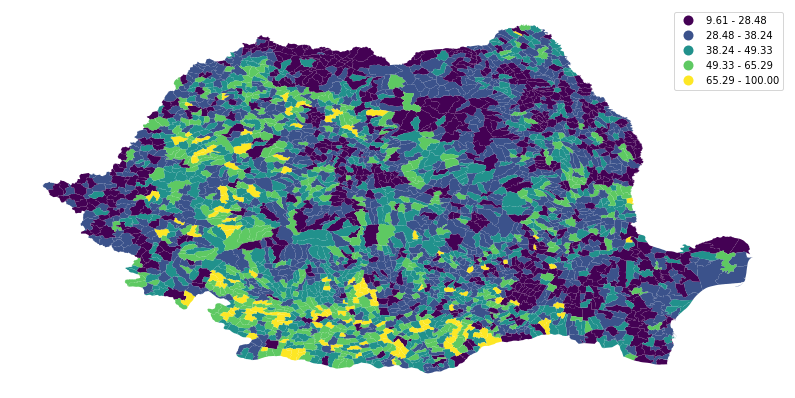

In [401]:
ax = geo.plot(figsize=(14, 10), column='turnout', legend=True, scheme='Fisher_Jenks');
fig = ax.get_figure()
fig.set_facecolor('#ffffff')
ax.set_axis_off()
fig.savefig('../../reports/rou_choropleth.png')